In [28]:
#Imports
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
#latest working version april 18 345pm

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load raw expression data ---
df = pd.read_csv("TCGA.STAD.expression.txt", sep="\t", index_col=0)
print("Original DataFrame:")
print(df.head())
print("Shape:", df.shape)

# --- Step 1: Remove columns with '?' in the name ---
question_mark_genes = [col for col in df.columns if '?' in col]
df_cleaned_cols = df.drop(columns=question_mark_genes)

# --- Step 2: Keep only gene names before '|' ---
new_columns = [col.split('|')[0] if '|' in col else col for col in df_cleaned_cols.columns]
df_cleaned_cols.columns = new_columns

# --- Step 3: Drop columns with any NaNs ---
df_no_nan = df_cleaned_cols.dropna(axis=1)

# ---  Ensure all remaining columns are numeric ---
df_no_nan = df_no_nan.loc[:, df_no_nan.dtypes.apply(lambda x: np.issubdtype(x, np.number))]

# --- Step 4: Remove lowly expressed genes (bottom 10% by sum) ---
gene_expression_sum = df_no_nan.sum(axis=0)
expression_threshold = gene_expression_sum.quantile(0.10)
genes_to_keep = gene_expression_sum[gene_expression_sum > expression_threshold].index
df_filtered = df_no_nan[genes_to_keep].copy()

# --- Step 5: Remove sex-linked genes ---
sex_genes = [
    'XIST', 'TSIX', 'JPX', 'KDM5D', 'RPS4Y1', 'EIF1AY', 'ZFY', 'UTY', 'DDX3Y', 'RPS4Y2',
    'TSPY1', 'USP9Y', 'AMELY', 'PRKY', 'SRY', 'RBMY1A1', 'RBMY1B', 'RBMY1D', 'RBMY1E',
    'TXLNGY', 'VCY', 'BCORP1', 'PCDH11Y', 'TBL1Y'
]
df_filtered_autosomal = df_filtered.drop(columns=[g for g in sex_genes if g in df_filtered.columns])

# --- Step 6: Remove low-variance genes (bottom 20%) ---
gene_variances = df_filtered_autosomal.var(axis=0)
var_threshold = gene_variances.quantile(0.20)
genes_to_keep = gene_variances[gene_variances > var_threshold].index
df_filtered_var = df_filtered_autosomal[genes_to_keep]

# --- Step 7: Log2 transformation ---
df_log2 = np.log2(df_filtered_var + 1)

# --- Step 8: Z-score normalization ---
df_z = df_log2.apply(zscore, axis=0)

# --- Step 9: Outlier detection (based on sample-wise mean absolute z-score) ---
sample_outlier_score = df_z.abs().mean(axis=1)
threshold = sample_outlier_score.quantile(0.975)
non_outlier_samples = sample_outlier_score[sample_outlier_score < threshold].index
df_no_outliers = df_log2.loc[non_outlier_samples]
print("Shape after removing outlier samples:", df_no_outliers.shape)


Original DataFrame:
                                 sample_id  ?|100130426  ?|100133144  \
patient_id                                                             
TCGA-CG-4460  TCGA-CG-4460-01A-01R-1157-13       0.0000    19.629800   
TCGA-CG-5716  TCGA-CG-5716-01A-21R-1802-13       0.0000    28.658900   
TCGA-HF-7131  TCGA-HF-7131-01A-11R-2055-13       0.4145     5.211200   
TCGA-3M-AB46  TCGA-3M-AB46-01A-11R-A414-31          NaN     9.031233   
TCGA-3M-AB47  TCGA-3M-AB47-01A-22R-A414-31          NaN    11.357840   

              ?|100134869     ?|10357      ?|10431  ?|136542    ?|155060  \
patient_id                                                                 
TCGA-CG-4460    15.746600  107.894000  1095.020000       0.0  132.456000   
TCGA-CG-5716    32.372100    0.000000   983.563000       0.0   81.588900   
TCGA-HF-7131    10.464200    0.696700   935.296000       0.0   47.722700   
TCGA-3M-AB46     9.330910  532.008647  2798.813956       NaN  201.067799   
TCGA-3M-AB47     4.

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.10it/s]


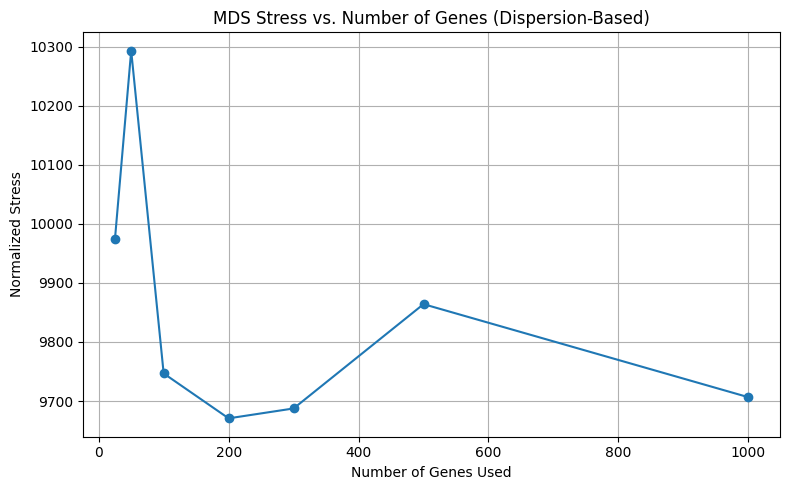

In [35]:
from tqdm import tqdm  # for a progress bar, optional

gene_counts = [25, 50, 100, 200, 300, 500, 1000]
stress_vs_gene_count = []

for n_genes in tqdm(gene_counts):
    # Get top N dispersed genes
    top_genes = dispersion_filtered.sort_values(ascending=False).head(n_genes).index
    df_subset = df_log2[top_genes].apply(zscore, axis=0)
    dist_matrix = squareform(pdist(df_subset, metric='correlation'))

    # Run MDS for 2 dimensions (or set n_components as desired)
    mds = MDS(
        n_components=2,
        dissimilarity='precomputed',
        random_state=42,
        max_iter=300,
        n_init=4,
        normalized_stress='auto',
        n_jobs=-1
    )
    mds.fit(dist_matrix)
    stress_vs_gene_count.append(mds.stress_)

# Plot Stress vs Number of Genes
plt.figure(figsize=(8, 5))
plt.plot(gene_counts, stress_vs_gene_count, marker='o')
plt.xlabel("Number of Genes Used")
plt.ylabel("Normalized Stress")
plt.title("MDS Stress vs. Number of Genes (Dispersion-Based)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
# Step 1: Compute mean and variance per gene
gene_means = df_log2.mean(axis=0)
gene_vars = df_log2.var(axis=0)

# Step 2: Compute dispersion (variance / mean)
dispersion = gene_vars / gene_means

# Step 3: Filter out low-mean genes (bottom 10%) to avoid unstable dispersion
min_mean_threshold = gene_means.quantile(0.10)
valid_genes = gene_means[gene_means > min_mean_threshold].index
dispersion_filtered = dispersion[valid_genes]

# Step 4: Get top 200 most dispersed genes
top_100_disp_genes = dispersion_filtered.sort_values(ascending=False).head(200).index
df_disp = df_log2[top_100_disp_genes].apply(zscore, axis=0)


In [47]:
from scipy.stats import zscore

# Subset log2 expression to top 100 dispersed genes
df_disp_raw = df_log2[top_100_disp_genes]

# Apply z-score normalization (gene-wise, across samples)
df_disp = df_disp_raw.apply(zscore, axis=0)

# Optional: confirm shape
print("Shape of z-scored top 100 dispersed genes:", df_disp.shape)


Shape of z-scored top 100 dispersed genes: (447, 200)


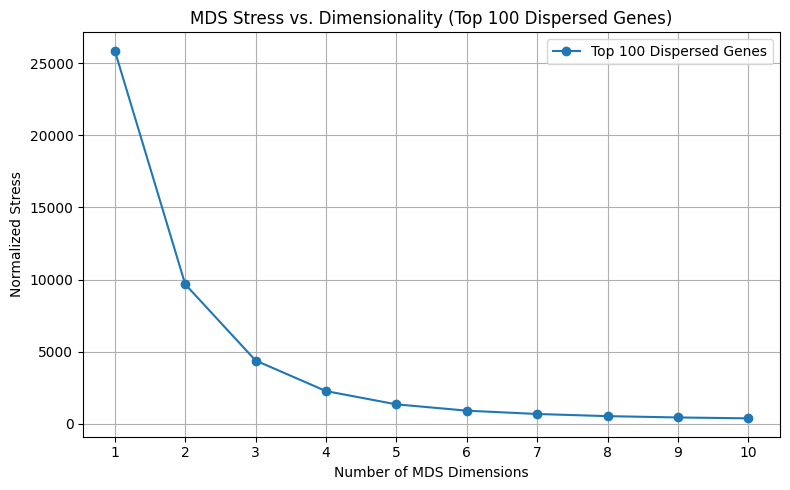

In [48]:
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Compute correlation distance matrix
dist_matrix_disp = squareform(pdist(df_disp, metric='correlation'))

# Track stress across dimensions
stress_disp = []
dims = range(1, 11)

for dim in dims:
    mds = MDS(
        n_components=dim,
        dissimilarity='precomputed',
        random_state=42,
        max_iter=300,
        n_init=4,
        normalized_stress='auto',
        n_jobs=-1
    )
    mds.fit(dist_matrix_disp)
    stress_disp.append(mds.stress_)

# Plot stress vs. number of dimensions
plt.figure(figsize=(8, 5))
plt.plot(dims, stress_disp, marker='o', label='Top 100 Dispersed Genes')
plt.xlabel("Number of MDS Dimensions")
plt.ylabel("Normalized Stress")
plt.title("MDS Stress vs. Dimensionality (Top 100 Dispersed Genes)")
plt.xticks(dims)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


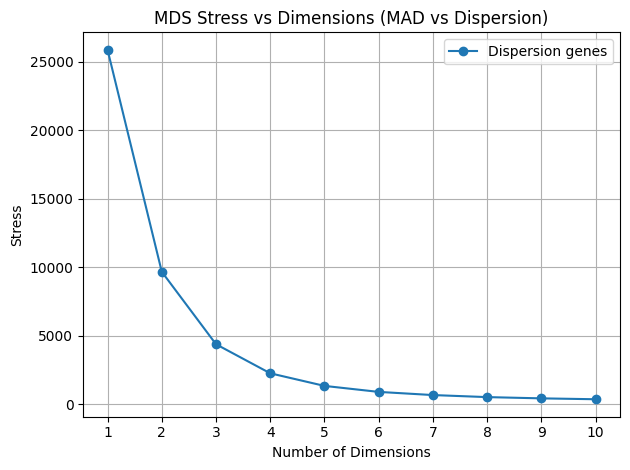

In [49]:
# Distance matrix for Dispersion genes
dist_matrix_disp = squareform(pdist(df_disp, metric='correlation'))

stress_disp = []
for dim in dims:
    mds = MDS(
        n_components=dim,
        dissimilarity='precomputed',
        random_state=42,
        max_iter=1000,
        n_init=4,
        normalized_stress='auto',
        n_jobs=-1
    )
    mds.fit(dist_matrix_disp)
    stress_disp.append(mds.stress_)

# Plot together
plt.plot(dims, stress_disp, marker='o', label='Dispersion genes')
plt.xlabel("Number of Dimensions")
plt.ylabel("Stress")
plt.title("MDS Stress vs Dimensions (MAD vs Dispersion)")
plt.xticks(dims)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# so we want 5 dimensions and using dispersion


In [45]:
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Distance matrix for your top 100 dispersed, z-scored genes
dist_matrix = squareform(pdist(df_disp, metric='correlation'))

# Load metadata
metadata = pd.read_csv("TCGA.STAD.metadata.txt", sep="\t")
metadata['patient_id'] = metadata['patient_id'].str.upper()

# Grid search settings
dims_to_try = [2, 3, 5]
inits_to_try = [1, 5, 10]
metrics_to_try = [True, False]

results = []

for dim in dims_to_try:
    for init in inits_to_try:
        for metric in metrics_to_try:
            mds = MDS(
                n_components=dim,
                dissimilarity='precomputed',
                metric=metric,
                n_init=init,
                max_iter=1000,
                eps=1e-5,
                random_state=42,
                normalized_stress='auto',
                n_jobs=-1
            )
            embedding = mds.fit_transform(dist_matrix)

            # Build MDS DataFrame
            col_names = [f"MDS{i+1}" for i in range(dim)]
            mds_df = pd.DataFrame(embedding, columns=col_names)
            mds_df['sample_id'] = df_disp.index
            mds_df['patient_id'] = mds_df['sample_id'].str[:12].str.upper()

            # Merge with metadata
            merged = mds_df.merge(metadata, on='patient_id', how='inner')

            # Silhouette score using tumor_status (or any label you choose)
            label_col = 'tumor_status'
            mask = merged[label_col].notna()
            sil = np.nan
            if mask.sum() >= 2 and merged[label_col].nunique() >= 2:
                sil = silhouette_score(merged[col_names][mask], merged.loc[mask, label_col])

            results.append({
                'n_components': dim,
                'n_init': init,
                'metric': metric,
                'stress': mds.stress_,
                'silhouette': sil
            })

# Compile results
grid_df = pd.DataFrame(results)
grid_df = grid_df.sort_values(['silhouette', 'stress'], ascending=[False, True])
print(grid_df)


    n_components  n_init  metric       stress  silhouette
15             5       5   False     0.181014   -0.060149
17             5      10   False     0.180915   -0.069823
13             5       1   False     0.182219   -0.074344
11             3      10   False     0.243228   -0.108244
12             5       1    True  1327.158203   -0.109600
14             5       5    True  1327.158203   -0.109600
16             5      10    True  1327.106471   -0.109676
3              2       5   False     0.302207   -0.111958
6              3       1    True  4368.950649   -0.145943
8              3       5    True  4368.950649   -0.145943
10             3      10    True  4368.950649   -0.145943
1              2       1   False     0.302654   -0.160205
7              3       1   False     0.243921   -0.165857
9              3       5   False     0.243921   -0.165857
0              2       1    True  9664.090643   -0.169178
2              2       5    True  9664.090643   -0.169178
4             

In [51]:
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import pandas as pd

# Compute correlation distance matrix on df_disp
dist_matrix = squareform(pdist(df_disp, metric='correlation'))

# Optimal MDS config (non-metric, 5D)
mds = MDS(
    n_components=5,
    dissimilarity='precomputed',
    metric=False,
    n_init=5,
    max_iter=1000,
    eps=1e-5,
    random_state=42,
    normalized_stress='auto',
    n_jobs=-1
)

# Fit and transform
embedding = mds.fit_transform(dist_matrix)

# Build MDS DataFrame
mds_df = pd.DataFrame(embedding, columns=[f'MDS{i+1}' for i in range(5)])
mds_df['sample_id'] = df_disp.index
mds_df['patient_id'] = mds_df['sample_id'].str[:12].str.upper()

# Load and merge metadata
metadata = pd.read_csv("TCGA.STAD.metadata.txt", sep="\t")
metadata['patient_id'] = metadata['patient_id'].str.upper()

# Merge MDS output with metadata
mds_merged = mds_df.merge(metadata, on='patient_id', how='inner')
print("Merged rows:", mds_merged.shape[0])


Merged rows: 447


In [52]:
from sklearn.metrics import silhouette_score
import numpy as np

# List of categorical metadata fields to evaluate
categorical_cols = [
    'tumor_status', 'vital_status', 'gender', 'race',
    'ajcc_pathologic_tumor_stage', 'histological_type',
    'histological_grade', 'type'
]

# List of numerical metadata fields to bin (quantile-based)
numeric_cols = ['age_at_initial_pathologic_diagnosis', 'OS.time', 'DSS.time', 'DFI.time', 'PFI.time']

# Combine into one list
all_cols = categorical_cols + numeric_cols

# Add MDS features
X = mds_merged[[f'MDS{i}' for i in range(1, 6)]]

# Store results
results = []

for col in all_cols:
    if col in numeric_cols:
        # Bin numeric columns into quantiles
        try:
            mds_merged[f'{col}_group'] = pd.qcut(mds_merged[col], q=2, duplicates='drop')
            label = mds_merged[f'{col}_group']
        except:
            continue  # skip if can't bin (e.g., all values same)
    else:
        label = mds_merged[col]

    mask = label.notna()
    if mask.sum() >= 2 and label[mask].nunique() >= 2:
        score = silhouette_score(X[mask], label[mask])
        results.append((col, round(score, 4)))
    else:
        results.append((col, np.nan))

# Print results
print("Silhouette Scores (5D MDS space):\n")
for col, score in results:
    print(f"{col:40s}: {score}")


Silhouette Scores (5D MDS space):

tumor_status                            : -0.0601
vital_status                            : -0.1053
gender                                  : 0.0001
race                                    : -0.1623
ajcc_pathologic_tumor_stage             : -0.1099
histological_type                       : -0.1662
histological_grade                      : -0.0485
type                                    : nan
age_at_initial_pathologic_diagnosis     : -0.001
OS.time                                 : 0.0014
DSS.time                                : 0.0014
DFI.time                                : -0.0023
PFI.time                                : 0.0013


/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


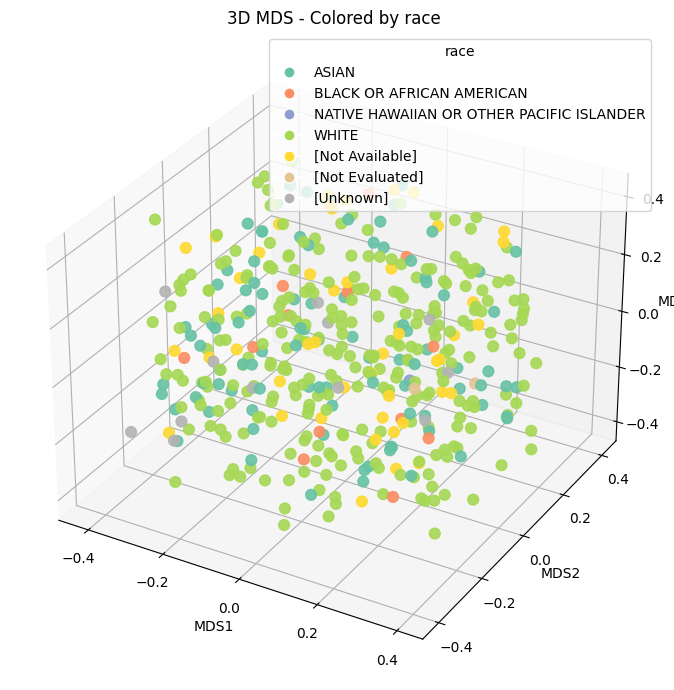

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


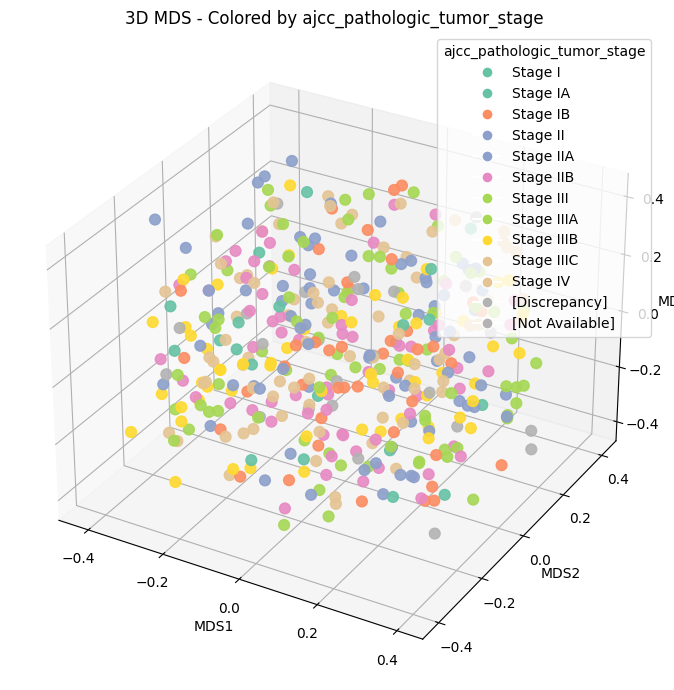

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


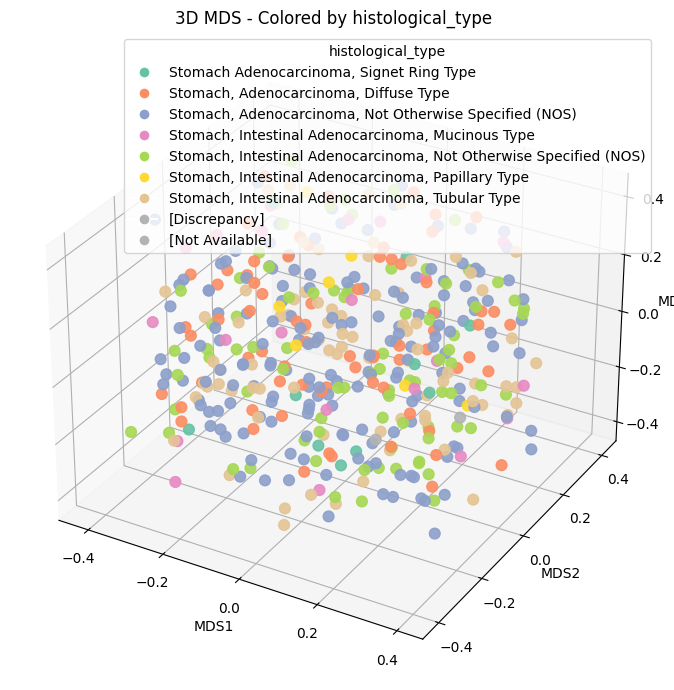

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


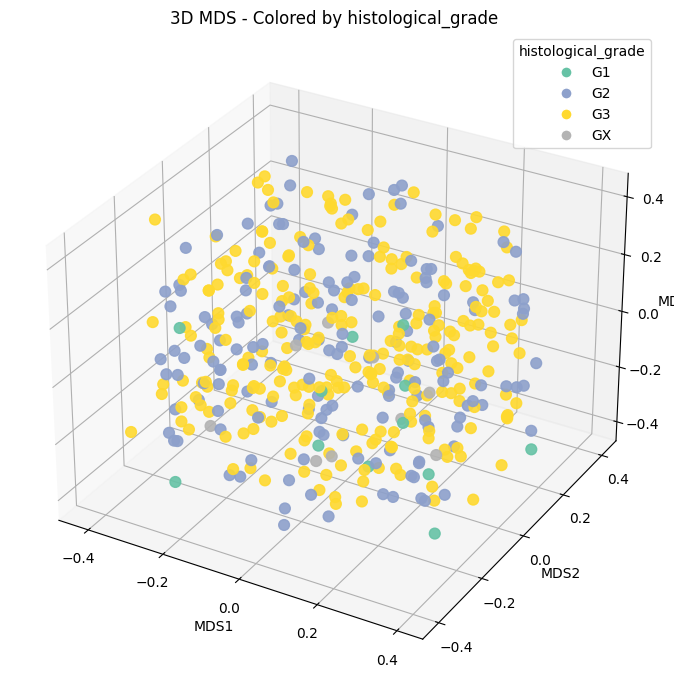

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


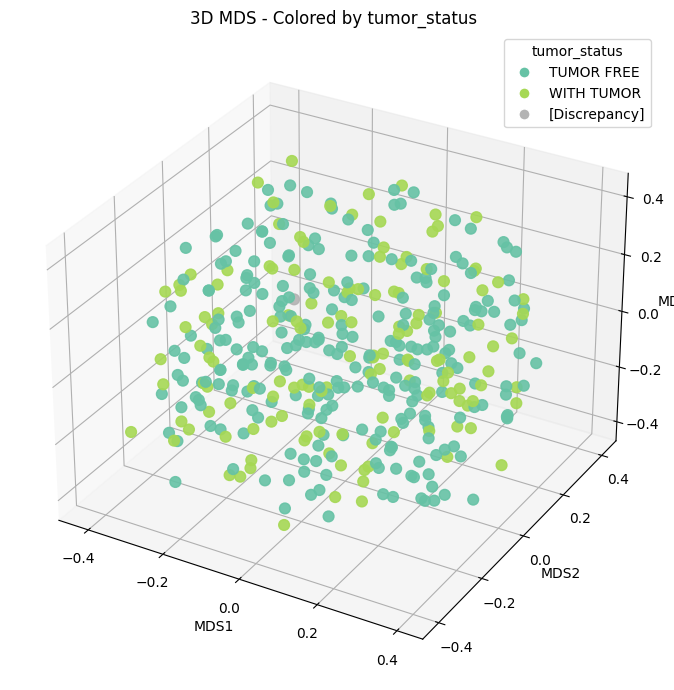

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


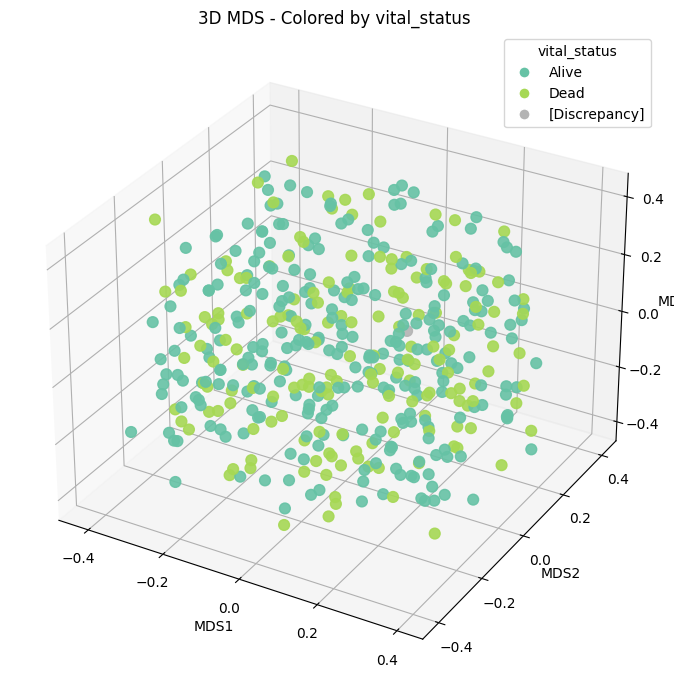

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


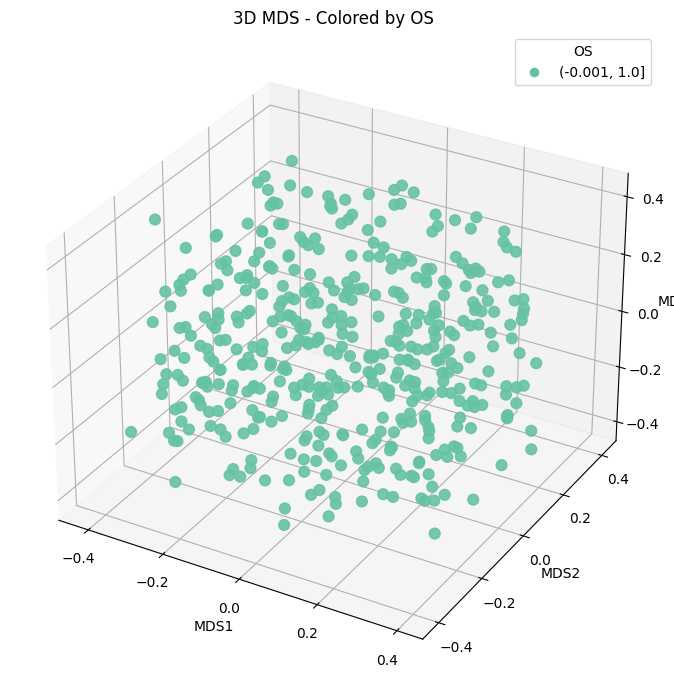

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}_binned'] = pd.qcut(data[col], q=3, duplicates='drop')
/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


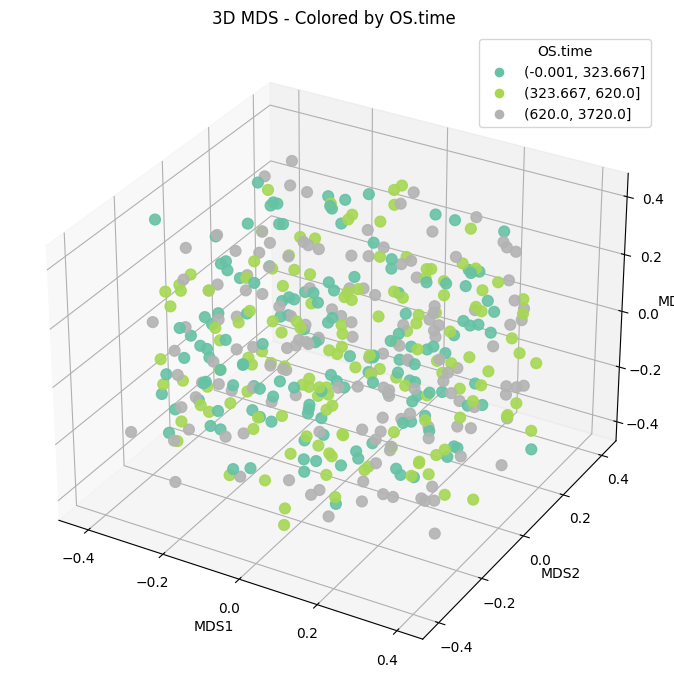

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}_binned'] = pd.qcut(data[col], q=3, duplicates='drop')
/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


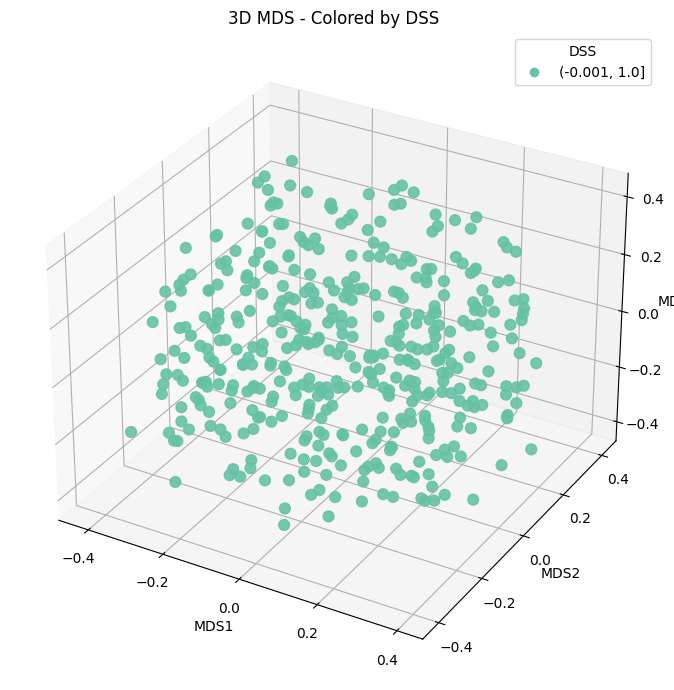

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}_binned'] = pd.qcut(data[col], q=3, duplicates='drop')
/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


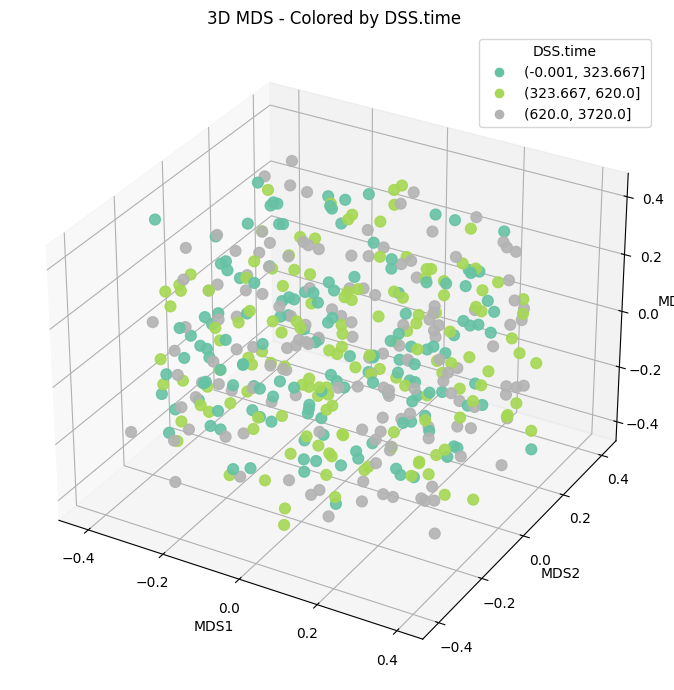

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}_binned'] = pd.qcut(data[col], q=3, duplicates='drop')
/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


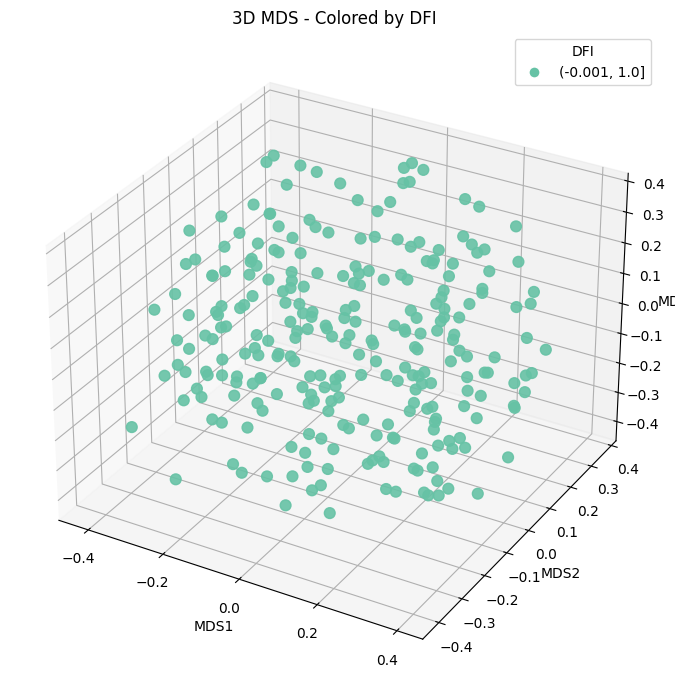

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}_binned'] = pd.qcut(data[col], q=3, duplicates='drop')
/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


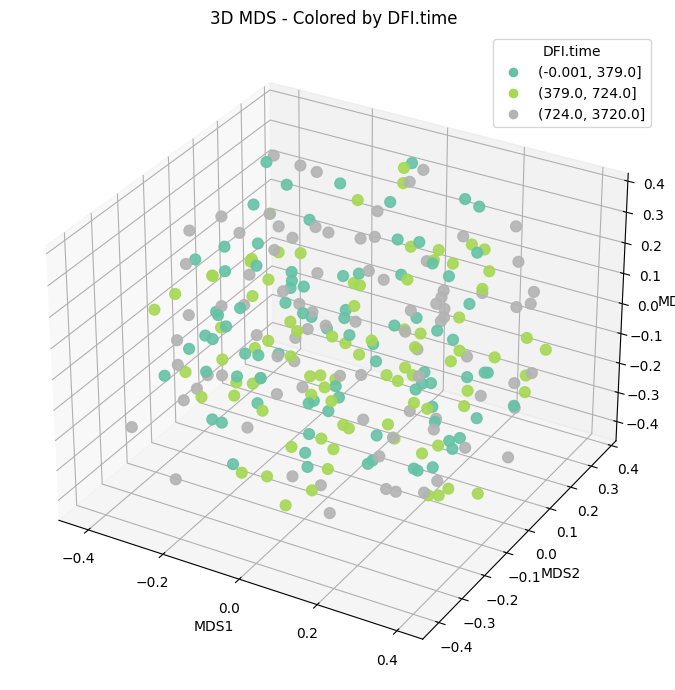

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


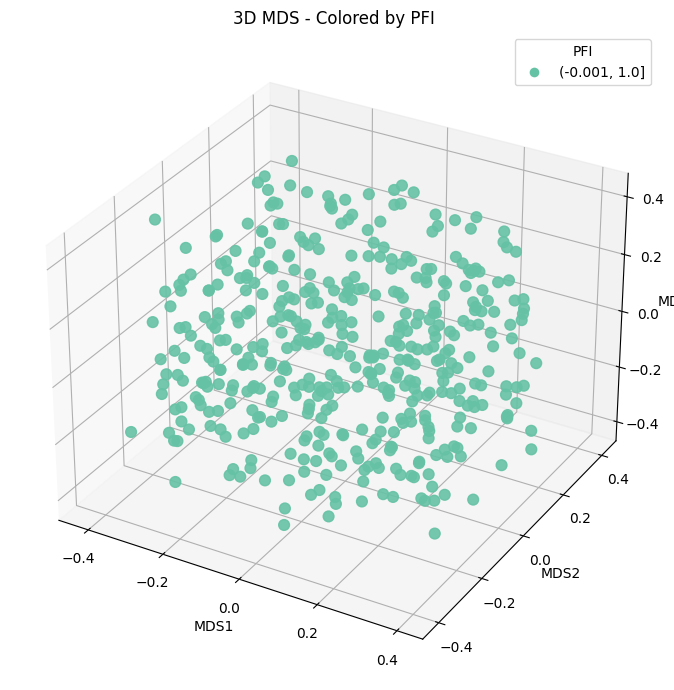

/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}_binned'] = pd.qcut(data[col], q=3, duplicates='drop')
/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_69295/2629657292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(labels))


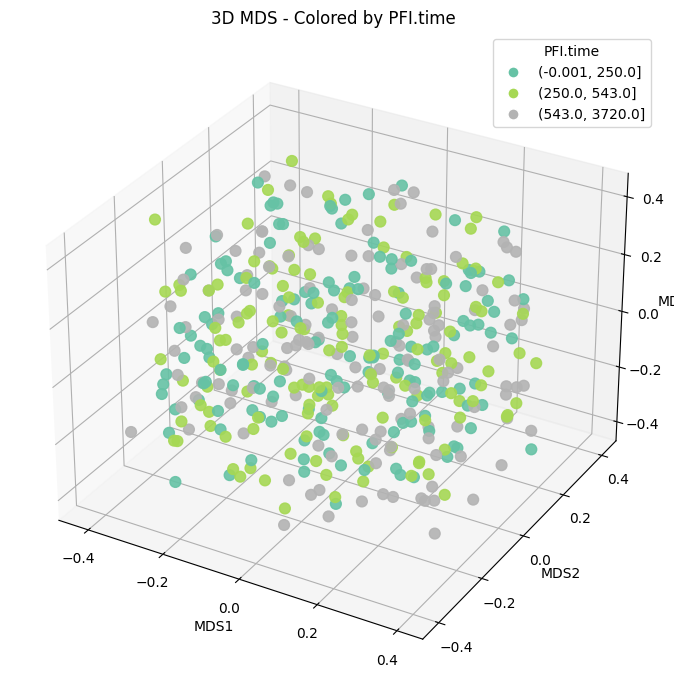

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import pandas as pd

# Selected metadata columns
metadata_columns = [
    'race', 'ajcc_pathologic_tumor_stage', 'histological_type', 'histological_grade',
    'tumor_status', 'vital_status', 'OS', 'OS.time', 'DSS', 'DSS.time',
    'DFI', 'DFI.time', 'PFI', 'PFI.time'
]

for col in metadata_columns:
    if col not in mds_merged.columns:
        continue

    # Drop missing values
    data = mds_merged.dropna(subset=[col])

    # For continuous variables like survival time, bin into 3 quantiles
    if pd.api.types.is_numeric_dtype(data[col]):
        try:
            data[f'{col}_binned'] = pd.qcut(data[col], q=3, duplicates='drop')
            display_col = f'{col}_binned'
        except:
            continue  # skip if binning fails (e.g., too few unique values)
    else:
        if data[col].nunique() < 2:
            continue
        display_col = col

    # Encode categories
    codes = data[display_col].astype('category').cat.codes
    labels = data[display_col].astype('category').cat.categories
    cmap = cm.get_cmap('Set2', len(labels))

    # Create 3D plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        data['MDS1'],
        data['MDS2'],
        data['MDS3'],
        c=codes,
        cmap=cmap,
        s=60,
        alpha=0.9
    )

    ax.set_title(f'3D MDS - Colored by {col}')
    ax.set_xlabel('MDS1')
    ax.set_ylabel('MDS2')
    ax.set_zlabel('MDS3')

    # Custom legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=cmap(i), markersize=8, label=str(label))
        for i, label in enumerate(labels)
    ]
    ax.legend(handles=legend_handles, title=col, loc='upper right')

    plt.tight_layout()
    plt.show()


In [54]:
from sklearn.metrics import silhouette_score

# Columns to test
categorical_cols = [
    'gender', 'race', 'ajcc_pathologic_tumor_stage', 'histological_type',
    'histological_grade', 'tumor_status', 'vital_status', 'type'
]

print("Silhouette Scores (MDS space):\n")
for col in categorical_cols:
    mask = mds_merged[col].notna()
    unique_vals = mds_merged.loc[mask, col].nunique()
    
    if mask.sum() >= 2 and unique_vals >= 2:
        score = silhouette_score(
            mds_merged[['MDS1', 'MDS2','MDS3']][mask],
            mds_merged.loc[mask, col]
        )
        print(f"{col}: {score:.4f}")
    else:
        print(f"{col}: Not enough groups or values to compute score")


Silhouette Scores (MDS space):

gender: -0.0026
race: -0.2055
ajcc_pathologic_tumor_stage: -0.1454
histological_type: -0.2351
histological_grade: -0.0957
tumor_status: -0.0986
vital_status: -0.1582
type: Not enough groups or values to compute score


In [55]:
print(mds_merged.columns.tolist())


['MDS1', 'MDS2', 'MDS3', 'MDS4', 'MDS5', 'sample_id', 'patient_id', 'type', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'histological_type', 'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction', 'age_at_initial_pathologic_diagnosis_group', 'OS.time_group', 'DSS.time_group', 'DFI.time_group', 'PFI.time_group']


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Drop missing values
df_model = mds_merged.dropna(subset=['tumor_status'])

X = df_model[['MDS1', 'MDS2','MDS3']]
y = df_model['tumor_status'].astype('category').cat.codes  # encode labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Logistic Regression:")
print(classification_report(y_test, lr.predict(X_test)))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Random Forest:")
print(classification_report(y_test, rf.predict(X_test)))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        48
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00         1

    accuracy                           0.59        81
   macro avg       0.20      0.33      0.25        81
weighted avg       0.35      0.59      0.44        81

Random Forest:
              precision    recall  f1-score   support

           0       0.60      0.92      0.73        48
           1       0.50      0.12      0.20        32
           2       0.00      0.00      0.00         1

    accuracy                           0.59        81
   macro avg       0.37      0.35      0.31        81
weighted avg       0.55      0.59      0.51        81



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classificat

In [57]:
# Bin OS.time into short vs long
df_model = mds_merged.dropna(subset=['OS.time']).copy()
df_model['OS_group'] = pd.qcut(df_model['OS.time'], q=2, labels=['Short', 'Long'])

X = df_model[['MDS1', 'MDS2','MDS3']]
y = df_model['OS_group'].astype('category').cat.codes

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Logistic Regression (Survival Group):")
print(classification_report(y_test, lr.predict(X_test)))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Random Forest (Survival Group):")
print(classification_report(y_test, rf.predict(X_test)))


Logistic Regression (Survival Group):
              precision    recall  f1-score   support

           0       0.45      0.31      0.37        45
           1       0.46      0.60      0.52        43

    accuracy                           0.45        88
   macro avg       0.45      0.46      0.44        88
weighted avg       0.45      0.45      0.44        88

Random Forest (Survival Group):
              precision    recall  f1-score   support

           0       0.55      0.58      0.57        45
           1       0.54      0.51      0.52        43

    accuracy                           0.55        88
   macro avg       0.54      0.54      0.54        88
weighted avg       0.55      0.55      0.54        88



In [58]:
from sklearn.cluster import KMeans

# Choose number of clusters (try a few values, e.g., 3–8)
kmeans = KMeans(n_clusters=5, random_state=42)
mds_df['cluster'] = kmeans.fit_predict(mds_df[['MDS1', 'MDS2', 'MDS3']])


/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


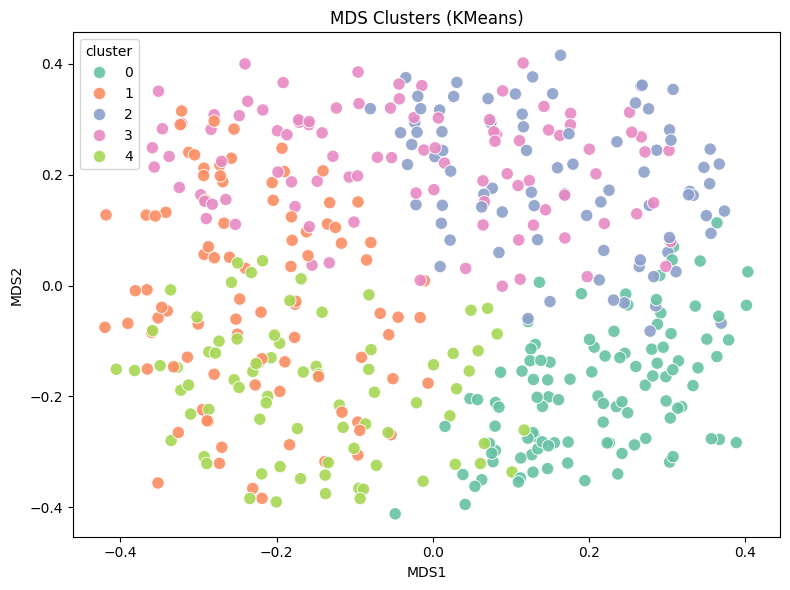

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=mds_df,
    x='MDS1',
    y='MDS2',
    hue='cluster',
    palette='Set2',
    s=80,
    alpha=0.9
)
plt.title("MDS Clusters (KMeans)")
plt.tight_layout()
plt.show()



In [60]:
from sklearn.metrics import silhouette_score

score = silhouette_score(mds_df[['MDS1', 'MDS2', 'MDS3']], mds_df['cluster'])
print("Silhouette Score:", score)


Silhouette Score: 0.28634502699307113


In [61]:
# Ensure patient_id is uppercase in both
mds_df['patient_id'] = mds_df['patient_id'].str.upper()
metadata['patient_id'] = metadata['patient_id'].str.upper()

# Merge clustered MDS data with metadata
clustered_df = mds_df.merge(metadata, on='patient_id', how='inner')

print("Merged DataFrame shape:", clustered_df.shape)
print("Columns:", clustered_df.columns.tolist())

# Optional: Preview
clustered_df[['cluster', 'ajcc_pathologic_tumor_stage', 'vital_status']].head()


Merged DataFrame shape: (447, 26)
Columns: ['MDS1', 'MDS2', 'MDS3', 'MDS4', 'MDS5', 'sample_id', 'patient_id', 'cluster', 'type', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'histological_type', 'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction']


,cluster,ajcc_pathologic_tumor_stage,vital_status
0,0,Stage IV,Dead
1,3,Stage IV,Alive
2,3,Stage IB,Alive
3,1,Stage IB,Alive
4,2,Stage IIIB,Dead
